In [267]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import re
from plot import plot_scaling
import seaborn as sns
%matplotlib inline

In [6]:
def extract_time(line):
    matched = re.search("Time (\d+\.\d+) \((\d+\.\d+)\)", line)
    if not matched:
        matched = re.search("Time   (\d\.\d\d) \(  (\d\.\d\d)", line)
    if matched:
        return float(matched.groups(1)[1])
def readfile(path):
    times = []
    for line in open(path).readlines():
        time = extract_time(line)
        if time:
            times.append(time)
    return times
!ls benchmark/ddp

ls: cannot access 'benchmark/ddp': No such file or directory


In [165]:
#folder = "ddp_30jan2022"
#folder = "ddp_15feb2022"
#folder = "test"
#folder = "ddp_14feb2022"
#folder = "ddp_15feb2022"
folder = "ddp_18feb2022"

files = glob(f"benchmark/{folder}/*.out")
rows = []
for f in files:
    f_basename = os.path.basename(f)
    f_basename = f_basename.replace(".out", "")
    toks = f_basename.split("_")
    if len(toks) == 7:
        nodes,bs,precision,model_name, model_size, expmode, run_id =  toks
        gpus_per_node = 4
    elif len(toks) == 8:
        nodes,gpus_per_node,bs,precision,model_name, model_size, expmode, run_id =  toks
    nodes = int(nodes)
    gpus_per_node = int(gpus_per_node)
    run_id = int(run_id)
    times = readfile(f)
    bs = int(bs)
    if len(times)==0:
        continue
    #imps  = int(bs)/times[-1]
    rows.append({"bs": bs, "secs_per_batch": times[-1], "nodes": nodes, "gpus_per_node": gpus_per_node, "type": "ddp", "precision":precision})
df = pd.DataFrame(rows)
df['gpus'] = df['gpus_per_node'] * df['nodes']
df.sort_values(by='gpus')

,bs,secs_per_batch,nodes,gpus_per_node,type,precision,gpus
7,16,0.5555,1,1,ddp,mixed,1
6,16,0.5740,1,4,ddp,mixed,4
9,16,0.5788,2,4,ddp,mixed,8
1,16,0.6040,4,4,ddp,mixed,16
8,16,0.6124,8,4,ddp,mixed,32
5,16,0.6229,16,4,ddp,mixed,64
2,16,0.6417,32,4,ddp,mixed,128
4,16,0.6484,64,4,ddp,mixed,256
0,16,0.6965,128,4,ddp,mixed,512
3,16,0.8024,256,4,ddp,mixed,1024


,precision,bs,secs_per_batch,nodes,gpus_per_node,type,gpus,baseline,scaling,efficiency
7,mixed,16,0.5555,1,1,ddp,1,0.5555,1.000000,1.000000
6,mixed,16,0.5740,1,4,ddp,4,0.5555,3.871080,0.967770
9,mixed,16,0.5788,2,4,ddp,8,0.5555,7.677954,0.959744
1,mixed,16,0.6040,4,4,ddp,16,0.5555,14.715232,0.919702
8,mixed,16,0.6124,8,4,ddp,32,0.5555,29.026780,0.907087
5,mixed,16,0.6229,16,4,ddp,64,0.5555,57.074972,0.891796
2,mixed,16,0.6417,32,4,ddp,128,0.5555,110.805672,0.865669
4,mixed,16,0.6484,64,4,ddp,256,0.5555,219.321407,0.856724
0,mixed,16,0.6965,128,4,ddp,512,0.5555,408.350323,0.797559
3,mixed,16,0.8024,256,4,ddp,1024,0.5555,708.913260,0.692298


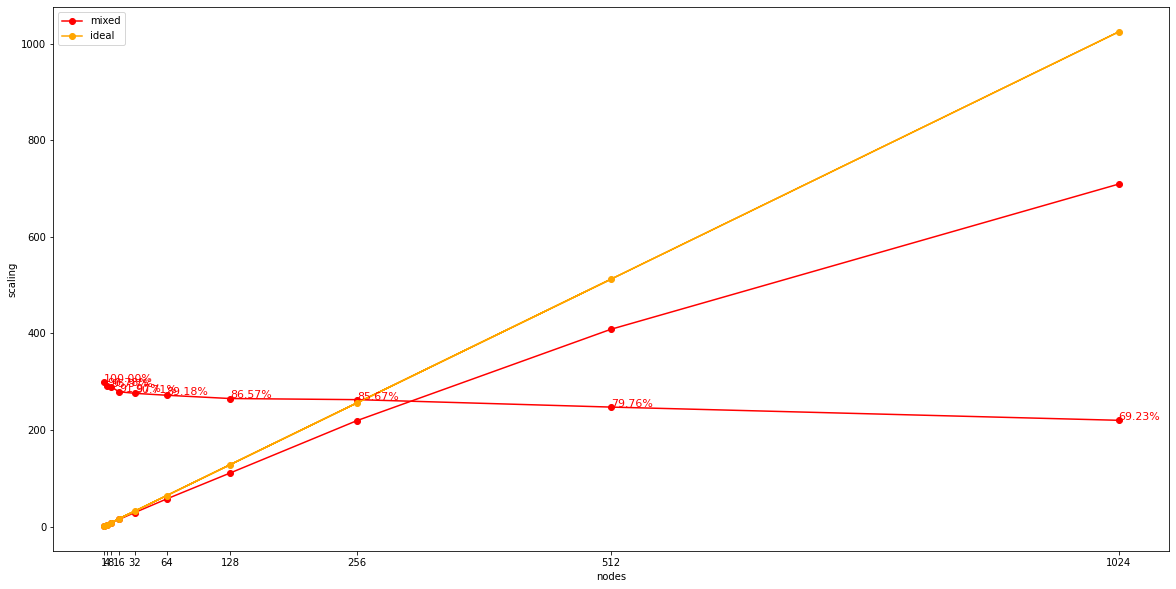

In [124]:
params  = {
    "ymin": 220,
    "ymax": 300
}
res = plot_scaling(
    df,  name_col="precision", node_col="gpus", time_col="secs_per_batch", 
    plot_efficiency=True, efficiency_params=params, figsize=(20, 10)
)
res.sort_values(by="gpus")

In [350]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_scaling_and_efficiency(df, **kw):
    """
    Render scaling and efficiency plots

    - Scaling plot is the relationship between the number of GPUs used
      and the speedup in the throughput
    - Efficiency is the ratio of throughput to ideal reference throughput
    """
    df = df.copy()
    # Number of GPUs per run
    df["GPUs"] = df["gpus"]
    df = df.sort_values(by="GPUs")

    # reference number of GPUs is the run with minimal number of GPUs
    refrence_nb_gpus = df.iloc[0]['GPUs']
    # reference throughput is the throughput of the configuration with the reference number of GPUs
    reference_secs = df.iloc[0]["secs_per_batch"]
    df["Speedup"] = (reference_secs / df['secs_per_batch']) * df['gpus']
    # efficiency is the  $E(K) = 100 \times \frac{T(K)}{K \times T(1)}$, where:
    # - $K$ is the number of GPUs
    # - $T(K)$ is the throughput for $K$ GPUs
    # - $T(1)$ the reference throughput (for $K=1$)
    df['efficiency'] =  reference_secs/ df["secs_per_batch"]
    scale = df.Speedup.max() * 1.5
    top = 0
    text_spacing = 0.4

    min_node = 8
    df = df[df.nodes>=min_node]
    cs = clip_scaling[clip_scaling.nodes>=min_node]

    # plot
    fig, ax1 = plt.subplots(**kw)
    plt.xticks(fontsize=18) 
    plt.yticks(fontsize=22) 

    y = df['efficiency'] * 100#* scale + top

    ax1.set_ylabel('Efficiency (%)', color='red', fontsize=22)
    ax1.plot(df.GPUs, y, c='red', marker="o", label='efficiency')
    #ax1.plot(cs.gpus, cs.Efficiency, c='green', marker="o", label='efficiency')

    ax1.tick_params(axis='y', labelcolor='red')
    ax1.set_xlabel('GPUs', fontsize=15)
    
    for nb_gpus, effval, yval in zip(df.GPUs, df['efficiency'], y):
        ax1.text(nb_gpus, yval+text_spacing, f"{effval*100:.2f}%", size=16, c='red')
        
        
    ax2 = ax1.twinx()
    plt.xticks(fontsize=18) 
    plt.yticks(fontsize=22) 

    ax2.plot(df.GPUs, df.Speedup, 'go--', label='Speedup (SLIP ViT-L/14)', color='blue')
    #ax2.plot(cs.gpus, cs.Speedup, 'go--', label='Speedup (CLIP ViT-B/32)', color='green')

    ax2.set_xlabel('GPUs')
    ax2.set_ylabel('Speedup',color='blue', fontsize=22)
    ax2.set_xticks(df.GPUs)
    ax2.plot(df.GPUs, df.GPUs / refrence_nb_gpus, 'go-', label='Ideal speedup', color='orange')

    ax2.tick_params(axis='y', labelcolor='blue')
    plt.xlabel("Number of GPUs")
    plt.legend(loc='upper center', fontsize=22)
    
def plot_images_per_sec(df, **kw):
    """
    Render raw images per sec plot
    """
    df = df.copy()
    df["GPUs"] = df['gpus']
    df = df.sort_values(by="GPUs")
    df['Sample/s'] = ((df.bs) / df.secs_per_batch) * df.gpus
    df['Ideal'] = (df.bs / df.secs_per_batch.iloc[0]) * df.gpus
    fig = plt.figure(**kw)
    #ax= df.plot(x="GPUs",  y="Sample/s", color='pink', edgecolor='red', kind='bar')
    #df.plot(x="GPUs",  y="ideal", color='lightgreen', edgecolor='green', kind='bar',ax=ax)
    plt.xticks(fontsize=22) 
    plt.yticks(fontsize=22) 

    plt.bar(df['GPUs'].apply(str), df['Sample/s'], color='pink', edgecolor='red', label='Sample/s (SLIP ViT-L/14)')
    plt.bar(df['GPUs'].apply(str), df['Ideal']-df['Sample/s'], color='red', edgecolor='red', bottom=df['Sample/s'], label='Ideal')
    plt.xlabel("GPUs", fontsize=22)

    plt.legend(fontsize=22, loc='best')


clip_scaling = [
    {"nodes": 1, "gpus": 1, "secs_per_batch": 0.26,    "Sample/s": 966.5, "Speedup": 1.00, "Efficiency": 100.00},
    {"nodes": 1, "gpus": 4,"secs_per_batch": 0.28,     "Sample/s": 3643.8, "Speedup": 3.77, "Efficiency": 94.25},
    {"nodes": 2, "gpus": 8,"secs_per_batch": 0.28,    "Sample/s": 7233.2, "Speedup": 7.48, "Efficiency": 93.55},
    {"nodes": 4, "gpus": 16,"secs_per_batch": 0.29,    "Sample/s": 14067.0, "Speedup": 14.55, "Efficiency": 90.96},
    {"nodes": 8, "gpus": 32,"secs_per_batch": 0.29,   "Sample/s": 27848.7, "Speedup": 28.8, "Efficiency": 90.04},
    {"nodes": 16, "gpus": 64,"secs_per_batch": 0.30,  "Sample/s": 54584.7, "Speedup": 56.5, "Efficiency": 88.24},
    {"nodes": 32, "gpus": 128,"secs_per_batch": 0.32,  "Sample/s": 102631.7, "Speedup": 106.2, "Efficiency": 82.96},
    {"nodes": 64, "gpus": 256,"secs_per_batch": 0.37, "Sample/s": 177322.3, "Speedup": 183.5, "Efficiency": 71.67},
]
clip_scaling = pd.DataFrame(clip_scaling)

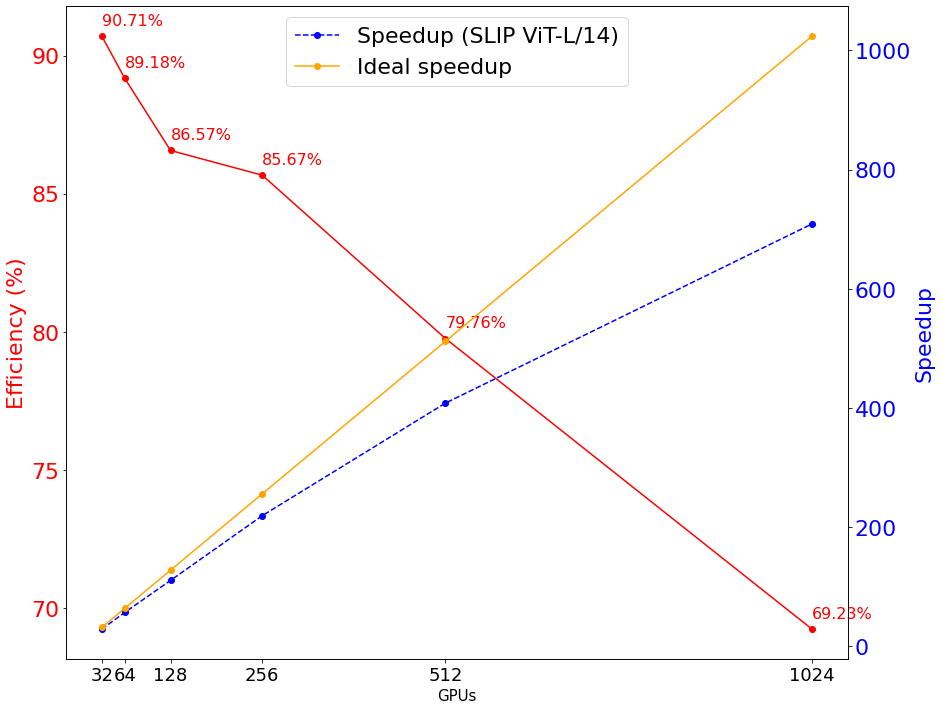

In [351]:
plot_scaling_and_efficiency(df, figsize=(14,12))
plt.savefig("scaling_efficiency_vitl14.pdf")

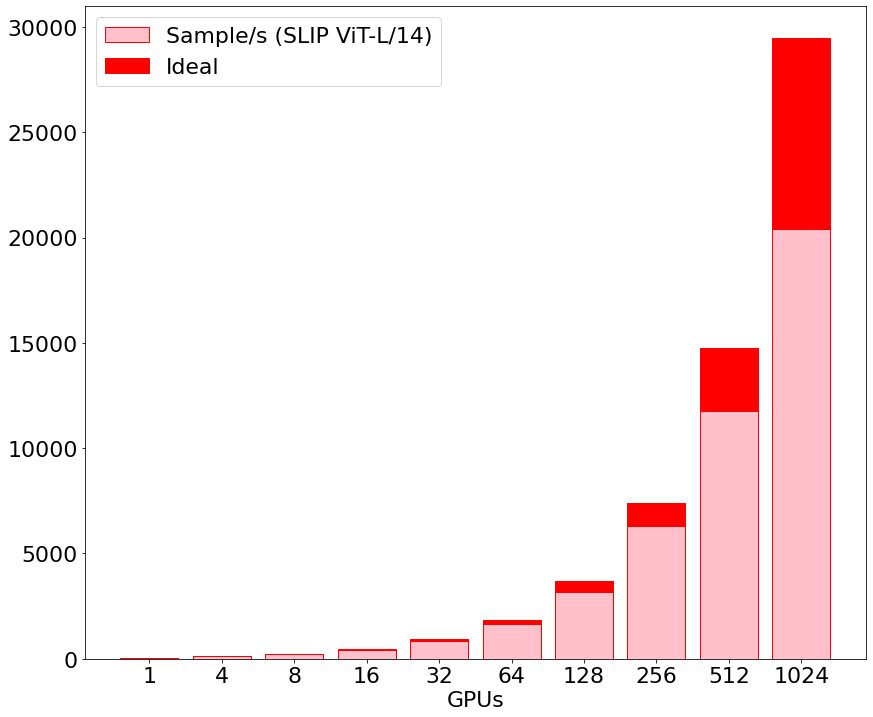

In [343]:
plot_images_per_sec(df, figsize=(14,12))

In [125]:
def gen_table(df):
    lines = ["\\#nodes & \\#GPUs  & Secs per batch & Sample /s & Speedup & Efficiency (%)\\\\", "\\hline"]
    df = df.sort_values(by='gpus')
    for idx, row in df.iterrows():
        impersec = (float(row.bs) / row.secs_per_batch) * row.gpus
        line = f"{row.nodes} & {row.gpus} & {row.secs_per_batch:.2f} & {impersec:.2f} & {row.scaling:.2f} & {row.efficiency*100:.2f}\\\\"
        lines.append(line)
    return '\n'.join(lines)
print(gen_table(res))

\#nodes & \#GPUs  & Secs per batch & Sample /s & Speedup & Efficiency (%)\\
\hline
1 & 1 & 0.56 & 28.80 & 1.00 & 100.00\\
1 & 4 & 0.57 & 111.50 & 3.87 & 96.78\\
2 & 8 & 0.58 & 221.15 & 7.68 & 95.97\\
4 & 16 & 0.60 & 423.84 & 14.72 & 91.97\\
8 & 32 & 0.61 & 836.05 & 29.03 & 90.71\\
16 & 64 & 0.62 & 1643.92 & 57.07 & 89.18\\
32 & 128 & 0.64 & 3191.52 & 110.81 & 86.57\\
64 & 256 & 0.65 & 6317.09 & 219.32 & 85.67\\
128 & 512 & 0.70 & 11761.67 & 408.35 & 79.76\\
256 & 1024 & 0.80 & 20418.74 & 708.91 & 69.23\\
